In [1]:
from isaacgym import gymapi
from isaacgym import gymutil
from isaacgym import gymtorch
from isaacgym.torch_utils import *
from genutil import *
from controllers import action, osc, compensate
from randomenvs import envinit
import math
import numpy as np
import torch

import os
from pathlib import Path
import time
import sys
torch.cuda.empty_cache()

sys.argv = ['generation_franka.ipynb','-ne=16','-f=0.1','-c','-ti=MS','-di','-is'] # BOTH FRICTION AND GRAVITY
#sys.argv = ['generation_franka.ipynb','-ne=32','-f=0.1','-c','-ti=MS', '-di', '-ds', '-dg'] # FRICTION
#sys.argv = ['generation_franka.ipynb','-ne=32','-f=0.1','-c','-ti=MS', '-di', '-ds', '-df'] # GRAVITY
#sys.argv = ['generation_franka.ipynb','-ne=32','-f=0.1','-c','-ti=MS', '-di', '-ds', '-df', '-dg'] # NEITHER FRICTION NOT GRAVITY

Importing module 'gym_38' (/home/gunes/isaacgym/tfm/RoboMorph/data_generation/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/gunes/isaacgym/tfm/RoboMorph/data_generation/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.0.1
Device count 1
/home/gunes/isaacgym/tfm/RoboMorph/data_generation/isaacgym/_bindings/src/gymtorch


Using /home/gunes/.cache/torch_extensions/py38_cu117 as PyTorch extensions root...
Emitting ninja build file /home/gunes/.cache/torch_extensions/py38_cu117/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


In [16]:
kp = torch.FloatTensor(16,1).uniform_(1,5).to("cuda:0")
kp.shape

torch.Size([16, 1])

In [5]:
kv = torch.FloatTensor(16).uniform_(1,5**0.5).to("cuda:0")
kv.shape

torch.Size([16])

In [14]:
pos_desired = torch.ones(16,3).to("cuda:0")
pos_current = (torch.ones(16,3)*5).to("cuda:0")

In [17]:
kp*(pos_desired-pos_current)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
args = parser(description="FrankaDataGen",params=[]).parse_arguments()
data = reader(path='data.json').read_data()


TOTAL_COORDS = data["TOTAL_COORDS"]
TOTAL_JOINTS = data["TOTAL_JOINTS"]
TOTAL_LINKS = data["TOTAL_LINKS"]

POS_END = np.array(data["POS_END"])
VEL_END = np.array(data["VEL_END"])
ACC_END = np.array(data["ACC_END"])
JER_END = np.array(data["JER_END"])
TOR_END = np.array(data["TOR_END"])
TAC_END = np.array(data["TAC_END"])
FRICTION = np.array(data["FRICTION"])
GRAVITY = data["GRAVITY"]

COULOMB_NOM = np.array(data["COULOMB_NOM"])
ANGDAMP_NOM = float(data["ANGDAMP_NOM"])
MASS_NOM = np.array(data["MASS_NOM"])
COM_NOM = np.array(data["COM_NOM"])
INERTIA_NOM = np.array(data["INERTIA_NOM"])
STIFFNESS_NOM = np.array(data["STIFFNESS_NOM"])
DAMPING_NOM = np.array(data["DAMPING_NOM"])
OSC_NOM = np.array(data["OSC_NOM"])

SOLVER_TIME = data["SOLVER_TIME"]/60
SUBSTEPS = data["SUBSTEPS"]
SOLVER_TYPE = data["SOLVER_TYPE"]
NUM_POS_ITER = data["NUM_POS_ITER"]
NUM_VEL_ITER = data["NUM_VEL_ITER"]

FIX_BASE_LINK = data["FIX_BASE_LINK"]
FLIP_VISUAL_ATTACHMENTS = data["FLIP_VISUAL_ATTACHMENTS"]
ARMATURE = data["ARMATURE"]

DISABLE_GRAVITY = args.disable_gravity     
DISABLE_FRICTION = args.disable_friction          
CONTROL_IMPOSED = args.control_imposed                                           
OSC_TASK = args.osc_task                                          
TYPE_OF_OSC = args.type_of_osc                            
NOPLOT = args.no_plot
INCLUDE_SATURATION = args.include_saturation                             

RANDOM_INIT_POS = args.random_initial_positions
RANDOM_INIT_VEL = args.random_initial_velocities        
RANDOM_MASS = float(args.random_masses)
RANDOM_INERTIA = float(args.random_inertias)
RANDOM_COM = float(args.random_coms)
RANDOM_STIFF = float(args.random_stiffness)
RANDOM_DAMP = float(args.random_damping)
RANDOM_COULOMB = float(args.random_coulomb_friction)
RANDOM_ANGDAMP = float(args.random_angular_damping)
RANDOM_KP_KV = args.random_osc_gains                              

INPUT_TYPE = args.type_of_input                          

VISUALIZE = args.visualize                            
NOSAVE = args.no_save
DYNAMICAL_INCLUSION = args.dynamical_inclusion       
TYPE_OF_DATASET = args.type_of_dataset                           
FREQUENCY = args.frequency                                        
NUM_ENVS = args.num_envs                                          
NUM_RUNS = args.num_runs                                    
MAX_ITER = args.num_iters

NUM_THREADS = args.num_threads
USE_GPU = args.use_gpu
USE_GPU_PIPELINE = args.use_gpu_pipeline
COMPUTE_DEVICE_ID = args.compute_device_id
GRAPHICS_DECIDE_ID = args.graphics_device_id
PHYS_ENGINE = args.physics_engine

iter_run = 1

complementary_dataset = 'train' if TYPE_OF_DATASET == 'test' else 'test'

output_folder = Path("./out_tensors/")
output_folder.mkdir(exist_ok=True)

current_folder = Path("./out_tensors/"+TYPE_OF_DATASET)
current_folder.mkdir(exist_ok=True)

complementary_folder = Path("./out_tensors/"+complementary_dataset)
complementary_folder.mkdir(exist_ok=True)

if not args.seed:
    generated_seed = np.random.randint(0,99999)
    copies = True
    while copies:    
        list_of_tensors = os.listdir("./out_tensors/"+complementary_dataset)
        generated_seed_str = 'seed_'+str(generated_seed)
        if any(generated_seed_str in s for s in list_of_tensors):
            generated_seed = np.random.randint(0,99999)
            print("\nCurrent Folder: "+TYPE_OF_DATASET+" --> Found the same seed in "+complementary_dataset)
            print("\nGenerated seed:"+str(generated_seed)) 
        else:
            copies=False
else:
    generated_seed = args.seed
print("\nGenerated Seed: "+str(generated_seed))
torch.manual_seed(generated_seed) 
#------------------------------------------------------------------------------------------------#         
print("\n ---------- This is run number :",iter_run, "----------")

gym = gymapi.acquire_gym()

TYPE_OF_CONTACT = gymapi.ContactCollection.CC_LAST_SUBSTEP 
sim_params = gymapi.SimParams()
sim_params.up_axis = gymapi.UP_AXIS_Z
sim_params.gravity = gymapi.Vec3(0.0, 0.0, -9.8)
sim_params.dt = SOLVER_TIME
sim_params.substeps = SUBSTEPS
if gymapi.SIM_PHYSX == PHYS_ENGINE:
    sim_params.physx.solver_type = SOLVER_TYPE
    sim_params.physx.num_position_iterations = NUM_POS_ITER
    sim_params.physx.num_velocity_iterations = NUM_VEL_ITER
    sim_params.physx.num_threads = NUM_THREADS
    sim_params.physx.use_gpu = USE_GPU
    sim_params.physx.contact_collection = TYPE_OF_CONTACT
else:
    raise Exception("Only PhysX is available")
sim_params.use_gpu_pipeline = USE_GPU_PIPELINE
sim = gym.create_sim(COMPUTE_DEVICE_ID, GRAPHICS_DECIDE_ID, PHYS_ENGINE, sim_params)
if sim is None:
    raise Exception("Failed to create sim")

plane_params = gymapi.PlaneParams()
plane_params.normal = gymapi.Vec3(0, 0, 1)
gym.add_ground(sim, plane_params)

num_per_row = int(math.sqrt(NUM_ENVS))
spacing = 1.0
env_lower = gymapi.Vec3(-spacing, -spacing, 0.0)
env_upper = gymapi.Vec3(spacing, spacing, spacing)

pose = gymapi.Transform()
pose.p = gymapi.Vec3(0, 0, 0)
pose.r = gymapi.Quat(0, 0, 0, 1)

ienv = envinit(args,
               gym, sim,
               env_lower, env_upper, num_per_row, pose,
               TOTAL_LINKS, TOTAL_JOINTS,
               FIX_BASE_LINK, FLIP_VISUAL_ATTACHMENTS, ARMATURE, DISABLE_GRAVITY, 
               ANGDAMP_NOM, MASS_NOM, COM_NOM, INERTIA_NOM, STIFFNESS_NOM, DAMPING_NOM, COULOMB_NOM,
               POS_END, VEL_END
               )
envdict = ienv.create_envs()

gym.prepare_sim(sim)

init_pos = torch.Tensor(envdict["ipos"]).view(NUM_ENVS, 3)
init_orn = torch.Tensor(envdict["iorn"]).view(NUM_ENVS, 4)

if args.use_gpu_pipeline:
    init_pos = init_pos.to('cuda:0')
    init_orn = init_orn.to('cuda:0')

pos_des = init_pos.clone()
orn_des = init_orn.clone()

_jacobian = gym.acquire_jacobian_tensor(sim, "franka") # (10,6,9)
jacobian = gymtorch.wrap_tensor(_jacobian)

hand_index = gym.get_asset_rigid_body_dict(envdict["fass"])["panda_hand"]
j_eef = jacobian[:, hand_index - 1, :]

_massmatrix = gym.acquire_mass_matrix_tensor(sim, "franka")
mm = gymtorch.wrap_tensor(_massmatrix)

_rb_states = gym.acquire_rigid_body_state_tensor(sim)
rb_states = gymtorch.wrap_tensor(_rb_states)

_simtorques = gym.acquire_dof_force_tensor(sim)
simtorques = gymtorch.wrap_tensor(_simtorques)

_contact_forces = gym.acquire_net_contact_force_tensor(sim) 
contact_forces = gymtorch.wrap_tensor(_contact_forces)

_dof_states = gym.acquire_dof_state_tensor(sim)
dof_states = gymtorch.wrap_tensor(_dof_states)
dof_vel = dof_states[:, 1].view(NUM_ENVS, 9, 1)
dof_pos = dof_states[:, 0].view(NUM_ENVS, 9, 1)
ll = torch.tensor(POS_END[:7,0]).repeat(NUM_ENVS,1).to(device=args.graphics_device_id)  
ul = torch.tensor(POS_END[:7,1]).repeat(NUM_ENVS,1).to(device=args.graphics_device_id)  
tl = torch.tensor(TOR_END[:7]).repeat(NUM_ENVS,1).to(device=args.graphics_device_id) 

if CONTROL_IMPOSED:
    ct = action(num_envs=NUM_ENVS,
                num_iter=MAX_ITER+1, 
                num_joints=TOTAL_JOINTS, 
                num_coords=TOTAL_COORDS,
                frequency=FREQUENCY,
                input_type=INPUT_TYPE,
                mass_vector=envdict["mv"],
                args=args)
    cdict = ct.getaction()

elif OSC_TASK:
    cosc = osc(num_envs=NUM_ENVS,
                num_iter=MAX_ITER+1, 
                num_joints=TOTAL_JOINTS, 
                num_coords=TOTAL_COORDS,
                frequency=FREQUENCY,
                input_type=INPUT_TYPE,
                mass_vector=envdict["mv"],
                args=args)
    
if not DISABLE_FRICTION or not DISABLE_GRAVITY:
    comp = compensate(args=args,
                      gravity=GRAVITY,
                      friction_params=FRICTION,
                      num_joints=TOTAL_JOINTS)
    
black_list = []  
out_of_range_quaternion = [] 
saturated_ll_idxs = []
saturated_ul_idxs = []
mesh = gymapi.MESH_VISUAL_AND_COLLISION
color = gymapi.Vec3(.9,.25,.15)


Generation MetaData from: data.json
Data stored in dict

Generated Seed: 16541

 ---------- This is run number : 1 ----------
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled

 No Mass randomization:
Nominal -->
[3.01 4.97 0.65 3.23 3.59 1.23 1.67 0.73 0.72 0.02 0.02]

 No CoM randomization:
Nominal -->
[[-0.0289  0.0039 -0.0031  0.0275 -0.0532 -0.012   0.0601  0.0105  0.
   0.     -0.    ]
 [-0.0008  0.0021 -0.0287  0.0393  0.1044  0.0411 -0.0141 -0.0043 -0.0009
   0.012  -0.012 ]
 [ 0.0565 -0.175   0.0035 -0.0665  0.0275 -0.0384 -0.0105  0.0616  0.0241
   0.0238  0.0238]]

 No Inertia randomization:
Nominal -->
[[ 9.100e-03  7.034e-01  8.000e-03  3.720e-02  2.590e-02  3.550e-02
   2.000e-03  1.250e-02  2.500e-03  0.000e+00  0.000e+00]
 [-1.000e-04 -1.000e-04 -3.900e-03 -4.800e-03  7.800e-03 -2.100e-03
   1.000e-04 -4.000e-04 -0.000e+00 -0.000e+00 -0.000e+00]
 [-1.400e-03  6.800e-03  1.030e-02 -1.140e-02 -1.300e-03 -4.000e-03

In [3]:
if VISUALIZE:
    viewer = gym.create_viewer(sim, gymapi.CameraProperties())
    if viewer is None:
        raise Exception("Failed to create viewer")
    cam_pos = gymapi.Vec3(4, 4, 4)
    cam_target = gymapi.Vec3(-4, -3, -2)
    middle_env = envdict["envs"][NUM_ENVS // 2 + num_per_row // 2]
    gym.viewer_camera_look_at(viewer, middle_env, cam_pos, cam_target)
    condition_window = gym.query_viewer_has_closed(viewer)
else:
    condition_window = 0 

itr = 0
ts = time.perf_counter()
while not condition_window  and itr <= MAX_ITER-1:
    itr += 1

    gym.refresh_rigid_body_state_tensor(sim)
    gym.refresh_dof_state_tensor(sim)
    gym.refresh_dof_force_tensor(sim)
    gym.refresh_jacobian_tensors(sim)
    gym.refresh_mass_matrix_tensors(sim)
    gym.refresh_net_contact_force_tensor(sim) 

    pos_cur = rb_states[envdict["hidx"], :3]
    orn_cur = rb_states[envdict["hidx"], 3:7]

    if OSC_TASK:
        u, ud = cosc(pos_des,orn_des,pos_cur,dof_vel,orn_cur,init_pos,j_eef,mm,itr) # DOF VEL PROBLEM INIT
        cdict["bt"] = torch.cat((cdict["bt"], pos_des.to("cpu").view( 1,NUM_ENVS, 3)), 0)  #target position
    elif CONTROL_IMPOSED:
        u = cdict["ac"][:,:,itr].unsqueeze(-1)
        ud = cdict["acd"][:,:,itr].unsqueeze(-1)

    if not args.disable_gravity:
        gtorque = comp.gravity(jacobian,envdict["mv"])
        u = u + gtorque
        cdict["bg"] = torch.cat((cdict["bg"],gtorque),dim=2)
    if not args.disable_friction:
        ftorque = comp.friction(dof_vel)
        u = u + ftorque
        cdict["bf"] = torch.cat((cdict["bf"],ftorque),dim=2)

    # ------------------------------------- APPLICATION OF U --------------------------------------------
    gym.set_dof_actuation_force_tensor(sim, gymtorch.unwrap_tensor(u))

    # ------------------------------------ CONTACT COLLECTION -------------------------------------------
    body_contact = torch.nonzero(abs(contact_forces)>0.01)

    for j in range(body_contact.shape[0]):
        _body_contact = body_contact[j].to("cpu").numpy()
        env_idx_collision = int(np.ceil(_body_contact[0]/TOTAL_LINKS)-1)
        if  not env_idx_collision in black_list : 
            black_list.append(env_idx_collision)
            env_handle = gym.get_env(sim,env_idx_collision)    
            for k in range(TOTAL_LINKS):
                gym.set_rigid_body_color(env_handle, envdict["fass"][0], k , mesh ,color)         
                
    # -------------------------------------- Step the physics --------------------------------------------
    gym.simulate(sim)
    gym.fetch_results(sim, True)
    if VISUALIZE:
        gym.step_graphics(sim)
        gym.draw_viewer(viewer, sim, False)
        gym.sync_frame_time(sim)

    # ----------------------------------- Stacking in the buffers -----------------------------------------
    if OSC_TASK:
        uaug, udaug = u, ud
        if DYNAMICAL_INCLUSION == True:
            uaug = torch.cat((uaug,envdict["mv"]),dim=2)
        cdict["bca"] = torch.cat((cdict["bca"], uaug), 2)
        cdict["bcad"] = torch.cat((cdict["bcad"], udaug), 2) 
    elif CONTROL_IMPOSED:
        uaug, udaug = u.view(1,NUM_ENVS,9)[:,:,:TOTAL_JOINTS], ud.view(1,NUM_ENVS,9)[:,:,:TOTAL_JOINTS]
        if DYNAMICAL_INCLUSION == True:
            uaug = torch.cat((uaug,envdict["mv"]),dim=2)
        cdict["bca"] = torch.cat((cdict["bca"], uaug), 0)
        cdict["bcad"] = torch.cat((cdict["bcad"], udaug), 0) 

    dof_states = gymtorch.wrap_tensor(_dof_states)
    dof_pos = dof_states[:, 0]
    dof_vel = dof_states[:, 1]

    dof_pos = dof_pos.view(1,NUM_ENVS,9)
    dof_pos = dof_pos[:,:,:7]
    dof_vel = dof_vel.view(1,NUM_ENVS,9)

    pos_cur = pos_cur.view(1,NUM_ENVS,3) 
    orn_cur = orn_cur.view(1,NUM_ENVS,4) 

    # -------------------------- INCLUDING dof_pos for 7 - dimension state space ---------------------------
    full_pose = torch.cat((pos_cur,orn_cur,dof_pos),dim = 2)     
    cdict["bp"] = torch.cat((cdict["bp"], full_pose), 0)
    cdict["bv"] = torch.cat((cdict["bv"], dof_vel), 0)        

    # -------------------------------- Sensor Measurement - Ground Truth -----------------------------------
    
    simtorques = gymtorch.wrap_tensor(_simtorques).view(1,NUM_ENVS,9)
    cdict["mt"] = torch.cat((cdict["mt"],simtorques),0)

    # ---------------------------------- Abnormal change in quaternion -------------------------------------
    if itr > 2:
        increment = abs(cdict["bp"][itr-1,:,3:7] - cdict["bp"][itr-2,:,3:7])
        out_of_range = torch.nonzero(increment > .1)
        if out_of_range.numel()!=0: 
            for x in out_of_range:
                out_of_range_quaternion.append(int(x[0].to('cpu').numpy()))
                cdict["bp"][itr-1,x[0],x[1]+3] = cdict["bp"][itr-1,x[0],x[1]+3]*-1
                rb_states[envdict["hidx"][x[0]], x[1]+3] = -1*rb_states[envdict["hidx"][x[0]], x[1]+3]

    # ---------------------------------- Saturation check | Position ---------------------------------------
    if CONTROL_IMPOSED:
        saturation_ll = torch.nonzero(abs(dof_pos-ll) < 0.01)
        saturation_ul = torch.nonzero(abs(dof_pos-ul) < 0.01)

        if saturation_ll.shape[0] != 0:
            for j in range(saturation_ll.shape[0]):
                saturated_ll_idxs.append(int(saturation_ll[j,1].to('cpu').numpy()))

        if saturation_ul.shape[0] != 0:
            for j in range(saturation_ul.shape[0]):
                saturated_ul_idxs.append(int(saturation_ul[j,1].to('cpu').numpy()))

    # ---------------------------------- Saturation check | Torque -----------------------------------------
    if OSC_TASK:
        saturation_torques = torch.nonzero( (tl - abs(cdict["ac"].squeeze(-1)[:,:7]) ) < 1)

        if saturation_torques.shape[0] != 0:
            for j in range(saturation_torques.shape[0]):
                saturated_ul_idxs.append(int(saturation_torques[j,0].to('cpu').numpy()))

tf = time.perf_counter()
dt = tf-ts
print(f"Time taken for simulation is {dt}")
if VISUALIZE:
    gym.destroy_viewer(viewer)
gym.destroy_sim(sim)   

Time taken for simulation is 4.3612310139997135


In [7]:
cdict["bca"].shape

torch.Size([1001, 5, 9])

In [4]:
if not INCLUDE_SATURATION:
    saturation_idxs = list(set(saturated_ul_idxs + saturated_ll_idxs))
    print("\n---- Number of saturated simulations: ",len(saturation_idxs),"/", NUM_ENVS,"----\n" )    
else:
    saturation_idxs = []
    print("Saturated environments are included in the final dataset\n")

out_of_range_quaternion = list(set(out_of_range_quaternion))
black_list = black_list + out_of_range_quaternion + saturation_idxs 
black_list = list(set(black_list))
failed_percentage = len(black_list)/NUM_ENVS*100

print("---- Number of simulations with abnormal changes in quaternions: ",len(out_of_range_quaternion),"/", NUM_ENVS,"----\n" )  
print("---- Number of the colliding simulations: ",len(black_list),"/", NUM_ENVS,"----\n" ) 
print("\n---- Number of rejectable simulations: ",len(black_list),"/", NUM_ENVS,"----\n" )  
print("Percentage of total rejectable simulations:", round(failed_percentage,2), "%") 

non_valid_envs = len(black_list)
num_valid_envs = NUM_ENVS - non_valid_envs

black_list.sort(reverse=True)

if DYNAMICAL_INCLUSION:
    envdict["mv"].repeat(MAX_ITER+1,
                         num_valid_envs,
                         TOTAL_JOINTS)

for i in range(non_valid_envs):
    row_exclude = black_list[i]
    if CONTROL_IMPOSED:
        cdict["bca"] = torch.cat((cdict["bca"] [:,:row_exclude,:],
                                                cdict["bca"] [:,row_exclude+1:,:]),1)
        cdict["mt"] = torch.cat((cdict["mt"] [:,:row_exclude,:],
                                                    cdict["mt"] [:,row_exclude+1:,:]),1)
    elif OSC_TASK:
        cdict["bca"] = torch.cat((cdict["bca"] [:row_exclude,:,:],
                            cdict["bca"] [row_exclude+1:,:,:]),0)
        cdict["bt"] = torch.cat((cdict["bp"] [:,:row_exclude,:],
                            cdict["bp"] [:,row_exclude+1:,:]),1)
    
        cdict["bp"] = torch.cat((cdict["bp"] [:,:row_exclude,:],
        cdict["bp"] [:,row_exclude+1:,:]),1)
        cdict["mt"] = torch.cat((cdict["mt"] [:,:row_exclude,:],
                                                    cdict["mt"] [:,row_exclude+1:,:]),1)
cdiff = cdict["bca"][:,:,:9] + cdict["mt"]

Saturated environments are included in the final dataset

---- Number of simulations with abnormal changes in quaternions:  11 / 16 ----

---- Number of the colliding simulations:  11 / 16 ----


---- Number of rejectable simulations:  11 / 16 ----

Percentage of total rejectable simulations: 68.75 %


Saving tensor input/output data
Control Dimension:torch.Size([1001, 5, 9])
Pose Dimension:torch.Size([1000, 16, 14])
Target Dimension:torch.Size([0, 16, 3])
Dynamical Inclusion Dimension:torch.Size([1, 16, 11])

Simulation to be saved as:
 16541_5_1000_01_G_F_NP_NV_0_0_0_0_0_0_0_NOSC_MS__train

Dataset saved with the above namespace

 Ready to Post-Process


IndexError: index 9 is out of bounds for dimension 2 with size 9

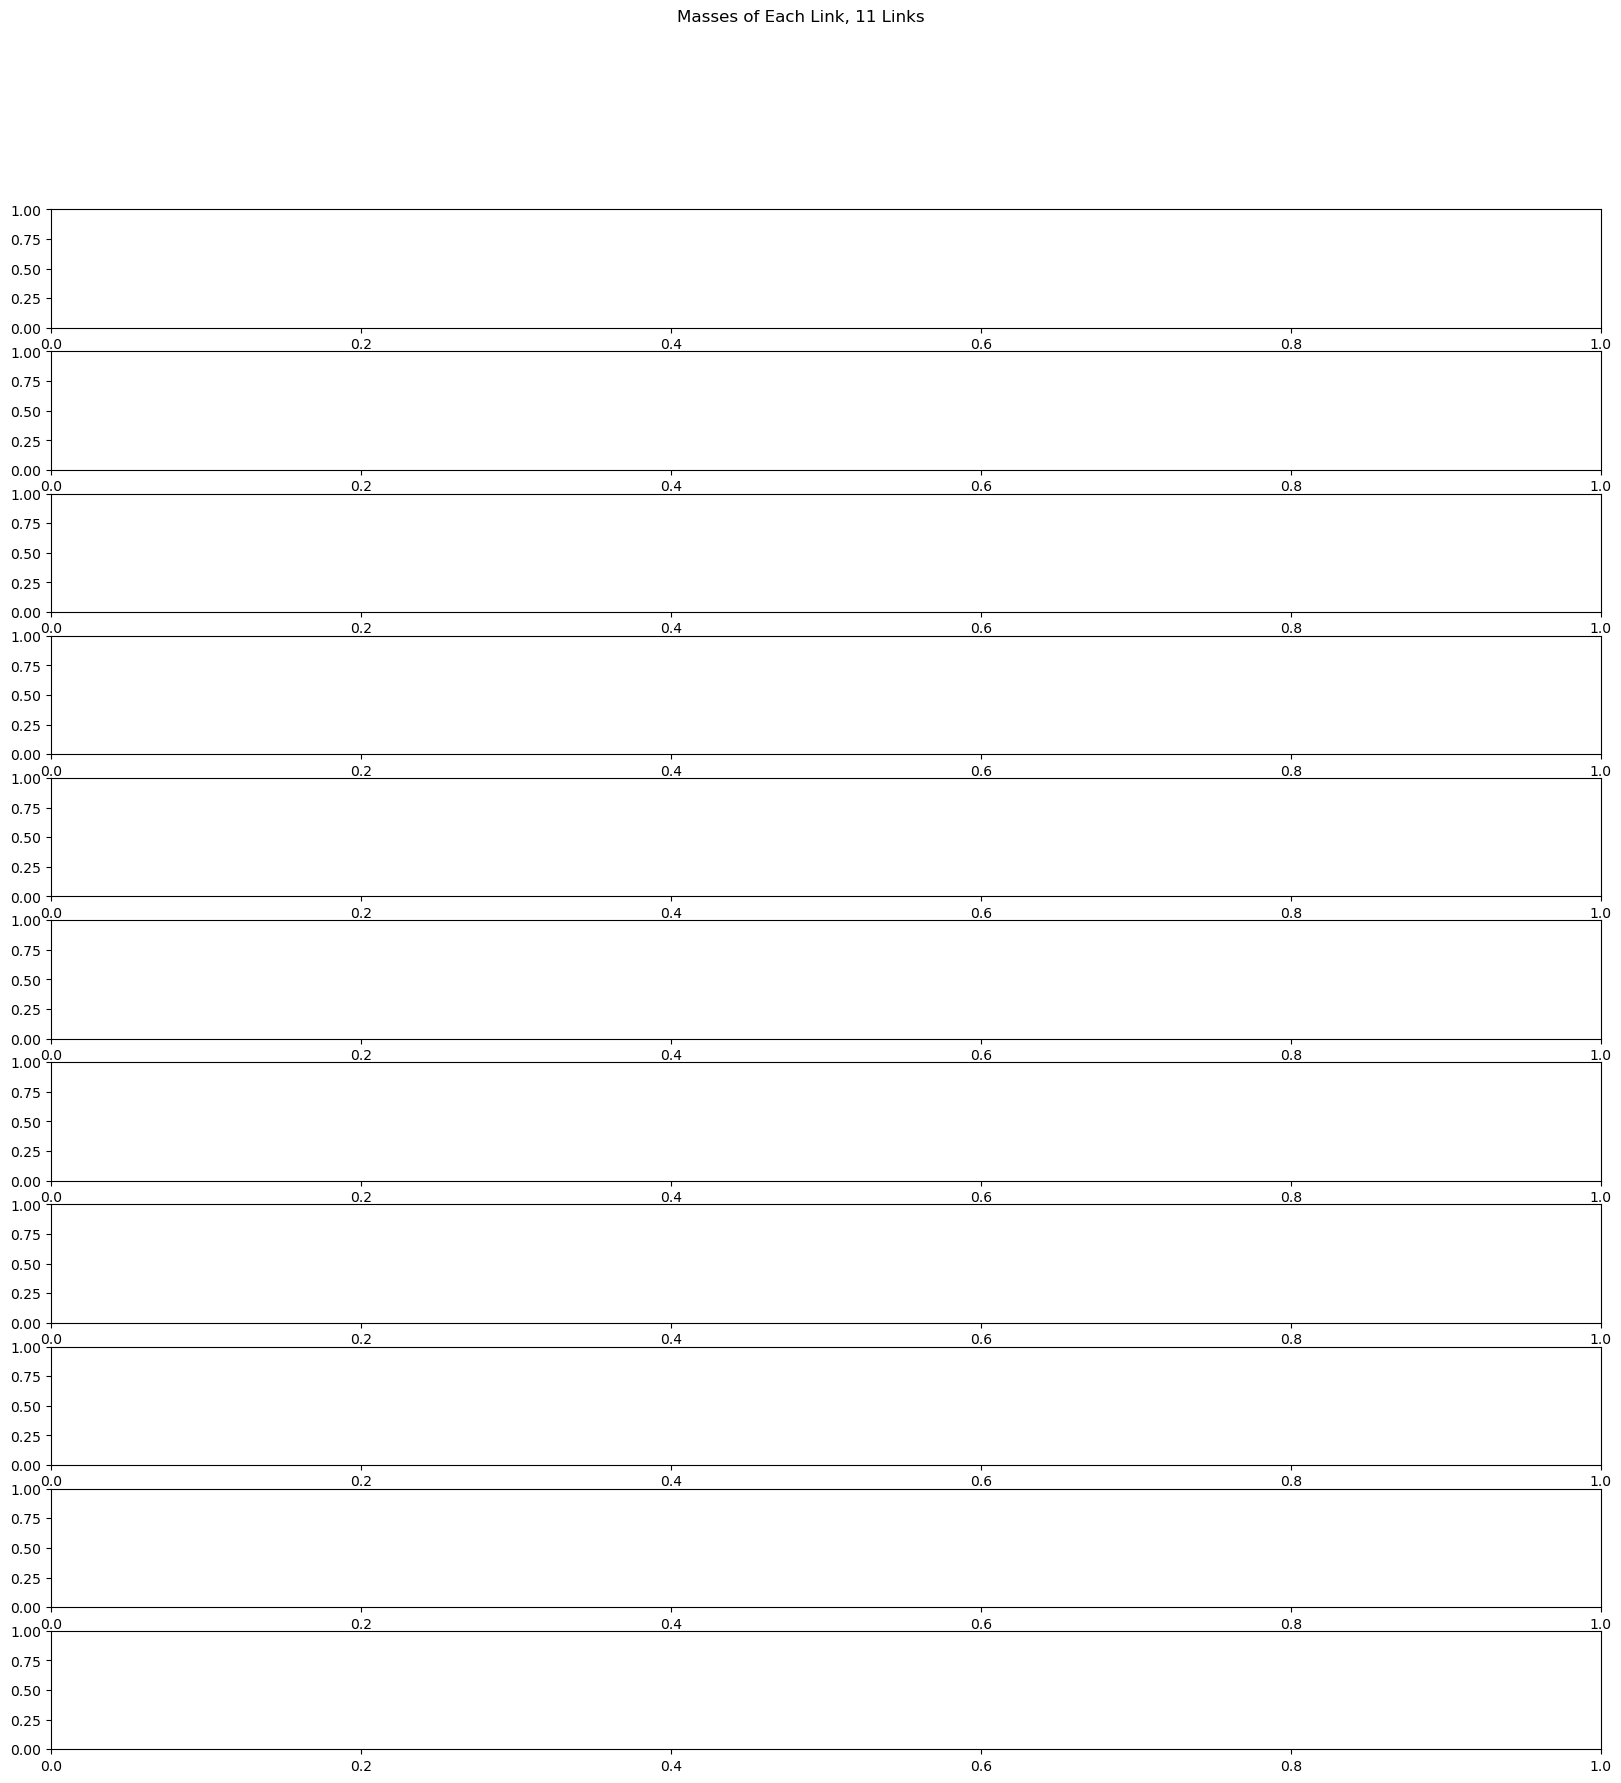

In [5]:
if not NOSAVE:
    tensormgmt = savedata(args,
                        control_trajectory=cdict["bca"],
                        pose=cdict["bp"],
                        seed=generated_seed,
                        valid_envs=num_valid_envs,
                        target=cdict["bt"],
                        dynamical_inclusion=envdict["mv"],
                        collision=None,
                        gentime=dt,
                        path='.')
    tensormgmt.save_tensors()
    tensormgmt.save_metadata()
else:
    print("Input/Output Tensors are not saved")
torch.cuda.empty_cache()

if not NOPLOT:
    dataprocessor = postprocessor(TOTAL_JOINTS,
                                TOTAL_COORDS,
                                args,
                                control_trajectory=cdict["bca"],
                                pose=cdict["bp"],
                                seed=generated_seed,
                                valid_envs=num_valid_envs,
                                target=cdict["bt"],
                                dynamical_inclusion=envdict["mv"]
                                )
    dataprocessor.plot_linkmassdist()
    dataprocessor.plot_control()
    dataprocessor.plot_secondary_var(var=torch.permute(cdict["mt"],(1,2,0)),varname="ground-truth control")
    dataprocessor.plot_secondary_var(var=torch.permute(cdiff,(1,2,0)),varname="benchmark control error")
    dataprocessor.plot_trajectory()
    dataprocessor.plot_secondary_var(var=torch.permute(cdict["bv"],(1,2,0)),varname="dof velocity")
    dataprocessor.plot_secondary_var(var=cdict["bg"],varname="gravity")
    dataprocessor.plot_secondary_var(var=cdict["bf"],varname="friction")
    dataprocessor.plot_saturation_histogram(pose=cdict["bp"][:,:,7:],limits=[ll,ul])
else:
    print("Input/Output Plots are not generated")